# REVEAL Motivational Test

Battleship https://en.wikipedia.org/wiki/Battleship_(game) is a simple game that is often used to test RL algorithms. You can find several solutions on the Internet by typing “battleship reinforcement learning”.
We would like you to implement a variant of the game and its solution (with any method of your choice). The variant is the following:
- only one player (the RL agent) plays against a program generating the battle situation
- all ships take up only a single square
- ships can touch each other and touch the board border eventually
- ships are placed on a 10x10 game board, not necessarily at random (the placement can from a specific distribution, which is the same from game to game)
- ships take several hits to sink (one take one hit, some take 2, some take 3)
The agent wins when all ships are sunk. The goal is to sink all ships with as few hits as possible.

In implementing this variant of the game and an agent that solves it, you may re-use and adapt existing code from the Internet (but you must give credit to the original authors). Your experiments will be performed in a Jupyter notebook. You will make your notebook available on GitHub and write a brief report pointing to your Gihub repo, explaining what you did, what you learned, and what work you would do in the future to improve on it. We value graphical representations and critical thinking.

I used the [gym python library](http://gym.openai.com/) from OpenAI by following [this basic tutorial](https://towardsdatascience.com/reinforcement-learning-with-openai-d445c2c687d2) as well as [this one](https://towardsdatascience.com/an-artificial-intelligence-learns-to-play-battleship-ebd2cf9adb01) focused on a battleship game implementation. [This other tutorial](https://towardsdatascience.com/creating-a-custom-openai-gym-environment-for-stock-trading-be532be3910e) goes through the creation of a custom gym environment. 

I also watched most of the videos from David Silver's course on RL [on youtube](https://www.youtube.com/watch?v=2pWv7GOvuf0) as I needed some theoretical framework to get started, Reinforcement Learning being completely new for me. 

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import truncnorm, uniform
import seaborn as sns
from collections import Counter

import matplotlib.pyplot as plt

plt.style.use('custom_basic')

I create a class for the game environment, that will handle every step of the game from creating or reseting the game board to accomplishing a given action (= shooting a square) and modifying the state in consequence. It is also able to render a very poor representation of the gameboard at any given step through the print function. 

The fleet (= the number and lives of the ships), the distribution used to place the ships as well as the grid size are specified when initalizing the class. Then, the *reset_board* can be called to reset all characteristics and start a new game while keeping the same hyperparameters. 


#### Class attributes : 
The class comes with many attributes, most of them are pretty straightforward. I will explain a few others : 


###### Board state
The *board_state* represents the true state of the current game, that the agent does not see. It gives all the ships placement, their current number of lives but also all the shot location(s), and the number of time they've been shot at. It is thus represented by a $grid\_size^2$ long vector. As all ships take up only a single square, the representation can be interverted between a square matrix and a $1D$ vector easily. 

###### Board observation
The *board_observation* is what the agent **can know** of the current board. At any given step, what the agent can see is : 

 - the number of times each square has been targeted
 - (the location of already sunk ships) ?
 - (the location of hit ships that are still afloat) ?
   
The *board_state* is thus a $1D$ vector of length $grid\_size^2$ like *board_state* where at each index appears the number of times this index has been targeted. 

This observation may not be the most efficient or the most useful as it is, but is is sufficiently flexible to be adapted for all future agents. 

In [2]:
class BattleshipEnv :
    
    def __init__(self, fleet = [1,2,2,2,3,3], grid_size = 10, 
                 distribution = uniform(loc = -50, scale = 99), 
                 rd_seed = None):
        """    
        Parameters
        ----------
        fleet : list of int
            A list containing all the ships that will be placed on the board. 
            The integer indicates the number of hits required to sink the ship. 
            The default means that 6 ships are placed on the board with 2 of them taking 3 hits before sinking.
        
        grid_size : int
            Determines the size of the game board, which is a grid of size (grid_size*grid_size).
            
        distribution : scipy distribution function
            The distribution used to place ships on the board. I'm using the scipy functions for flexibility 
            on the distribution used. 
            The distribution must be centered around 0, and grid_size//2 is later added to the samples.
            For a grid_size of 10, I tried with 2 different distributions : 
                uniform with : uniform(loc = -50, scale = 99)
                normal with : truncnorm(a= -50/10, b= 50/10, scale=10)
                
        rd_seed = int or float
            The seed used for pseudo random sampling. Can be used to recreate experiments.        
        """
        
        # General parameters : 
        self.grid_size = grid_size
        self.fleet = fleet
        self.distribution = distribution
        self.shots_count, self.hits_count = 0, 0
        # List to count the number of ships sunk by type (=lives)
        self.sunk_count = [0 for ship_type in set(fleet)]
        self.reward = 0
        self.episode_no = 0
        
        # Initiates a board configuration : 
        self.board_state, self.fleet_coords = self.create_board(fleet.copy(), rd_seed)
        self.initial_state = self.board_state.copy()
        
        # At first the observation is null
        self.board_observation = np.zeros((grid_size**2), dtype = 'int8')
        
    ## This function is used to generate the ship placement according to the fleet and seed passed as argument
    # The distribution used is specified during the first instanciation of the class
    def create_board(self, fleet, seed):
        
        # Sets the current seed used
        self.seed = seed
        
        # The board is represented as a 1 dimensional grid_size^2 array
        board_state = np.zeros((self.grid_size**2), dtype = 'int8')
        
        # A dictionnary containing all coordinates of the ships, mainly used for visual rendering
        fleet_coords = dict()
        
        # We sample a sufficient number of potential positions using the seed 
        placements = self.distribution.rvs(self.grid_size**3, random_state = seed).round().astype('int8')
        
        # while all ships have not been placed and there are still available positions sampled
        while fleet and len(placements):
            
            # We pop the next placement sampled
            position, placements = placements[0], placements[1:]
            
            # We shift the sampled position so that it is centered around half the grid_size
            position += (self.grid_size**2)//2
            
            # If the coordinates are not already taken 
            if not(board_state[position]) :
                ship = fleet.pop()
                # We add the ship to the board
                board_state[position] = ship
                # And to the dictionnary that stores coordinates when on a grid_size * grid_size array
                (y,x) = np.unravel_index(position, (self.grid_size, self.grid_size))
                fleet_coords[(x,y)] = str(ship)
        
        # Warns when the number of possible placements sampled was not sufficient to place all the ships
        # Dumb exception to catch this case and avoid infinite loop
        # But the number of sampled positions should be sufficient in all cases
        if fleet :
            print('Error : not all ships have been placed')
        
        return board_state, fleet_coords
            
        
    ## Function to reset the game after an episode is finished
    def reset_board(self, seed):
        self.shots_count, self.hits_count = 0, 0
        self.sunk_count = [0 for ship_type in set(self.fleet)]
        self.reward = 0
            
        self.board_state, self.fleet_coords = self.create_board(self.fleet.copy(), seed)
        self.initial_state = self.board_state.copy()
        
        self.board_observation = np.zeros((self.grid_size**2), dtype = 'int8')
            
        self.episode_no += 1
        
    ## Function used to get a visual representation of the board state :
    def render_board(self):
            
        print("Episode %d" % self.episode_no)

        horizontal_border = "----"*self.grid_size + "-" 
        
        # Gets the current board state as well as the original and reshape them to match our square visualization
        board_state = self.board_state.reshape((self.grid_size, self.grid_size)) 
        initial_state = self.initial_state.reshape((self.grid_size, self.grid_size)) 
        
        for y in range(self.grid_size):
            line_str = "|"
            for x in range(self.grid_size):
                    
                # Gets the number of lives of the ship located on this square. 
                # If no ship is there, it will print a blank space
                ship_lives = self.fleet_coords.setdefault((x,y), " ")
                  
                # If the current state is less than 0 but the original state was positive
                # a ship has been sunk at this location. We then display a "S" next to the ship original number of lives
                if board_state[y,x] <= 0 and initial_state[y,x] :
                    square_content = "S%s |" % ship_lives
                    
                # if the number of shots on this square is smaller or equal to three, then we display 3 x in the square
                elif board_state[y,x] <= -3 :
                    square_content = "xXx|"
                    
                # Otherwise, we display the number of shots on the square 
                # as well as the original lives of the ship if it was present
                elif board_state[y,x] == -2 :
                    square_content = "x%sx|" % ship_lives
                elif board_state[y,x] == -1 :
                    square_content = "x%s |" % ship_lives
                else :
                    square_content = " %s |" % ship_lives
                    
                line_str += square_content
                    
            print(horizontal_border)
            print(line_str)
               
        # Prints additional info on the current state
        print(horizontal_border +  "\n")
        print("Shots : %d / Hits : %d" % (self.shots_count, self.hits_count))
        print("Reward : %d" % self.reward) 
        print("#####################################\n")
        
        
    ## Function that performs an action and returns the corresponding reward, new state and new observation
    def take_step(self, action):           
            
        # The action is an integer between 0 and grid_size^2 (=the index)
        shot_y, shot_x = np.unravel_index(action, (self.grid_size, self.grid_size))
            
        # Creates two copies of the observation 
        current_obs, new_obs = self.board_observation.copy(), self.board_observation.copy()
        
        # Reward starts at -1 for taking a step
        reward = -1
        
        ### Reward 
        # Large penalty if the agent shot an already sunk ship
        if self.board_state[action] <= 0 and self.initial_state[action] > 0 :
            reward -= self.grid_size
            
        # Else, the agent gets a reward if it sinks a ship
        elif self.board_state[action] == 1 :
            reward += self.grid_size//2
            self.hits_count += 1
            
            # We also update the sunk_count list
            # go through all ship types
            for index, ship_type in enumerate(set(self.fleet)):
                # when the ship type matches the type of the one that has been sunk
                if ship_type == self.initial_state[action]:
                    # We add one to the count of the corresponding type
                    self.sunk_count[index] += 1
           
        # Else, if there is a ship at this location with more than 1 life, the reward is nullified
        elif self.board_state[action] > 1 :
            reward += 1
            self.hits_count += 1
        
        
        # We then change both the state and the observation
        self.board_state[action] -= 1
        new_obs[action] -= 1
        self.shots_count += 1
        
        # We return the old and new observations as well as the reward obtained
        # The board state is not returned as it is modified in the function
        return current_obs, new_obs, reward       

### Random agent

The first agent is completely random and does not learn. This serves both as a testing agent to check that the environment works and as a benchmark bottom for other learning agents. 

In [3]:
class random_agent :
    
    def __init__(self,
                 fleet = [1,2,2,2,3,3], grid_size = 10, 
                 distribution = uniform(loc = -8, scale = 15)) :
        
        # Initates the game instance
        self.battleshipBoard = BattleshipEnv(fleet = fleet, grid_size = grid_size, 
                                        distribution = distribution)
        
        # A dictionnary to store experiment results
        self.exp_results = {'reward' : [],
                            'shots' : []}
        
    ## Function for the agent to solve one board of the game
    def play_episode (self, gameboard,
                      agent_seed = None, verbose = 0):
        
        """
        Parameters
        ----------
        gameboard : a BattleshipEnv instance
        
        agent_seed : int
            seed to generate agent behavior
            
        verbose : int
            determines the output level of the agent. If 0, nothing is printed. 
            If 1, only the first and last state of each game is printed.
            If 2 or higher, the board state is printed after each action. 
        """
        
        agent_state = np.random.RandomState(seed = agent_seed)
        
        # Prints the starting state if required
        if verbose:
            print("Board initial state : ")
            print(gameboard.fleet_coords)
            gameboard.render_board()
            
        allSunk = False
        
        # while the game isn't solved
        while not(allSunk) :
            
            # A random action is sampled 
            action = agent_state.randint(0,gameboard.grid_size**2)
            
            # Accomplish the action and gets the new observation and the reward
            # (the old observation is useless here)
            _, gameboard.board_observation, reward = gameboard.take_step(action)
            
            # Updates the total reward
            gameboard.reward += reward
            
            # Prints the intermediate state if specified
            if verbose > 1 :
                gameboard.render_board()
            
            # The game continues until all ships are sunk
            allSunk = (sum(gameboard.sunk_count) == len(gameboard.fleet))
            
            
        # Prints the last true state
        if verbose :
            print('Board final state')
            gameboard.render_board()
            
        # We return only the number of turns needed as well as the reward obtained
        # as these are the only indicators useful for a random agent
        return gameboard.shots_count, gameboard.reward
            
    def train_agent(self, n_exps = 10000,
                    agent_seed = None, board_seed = None,
                    verbose = 0) :
        
        # Creates a list of seeds for both the agent behavior and the board initialization
        agent_seeds = np.random.RandomState(seed = agent_seed).randint(0, 2**30, n_exps)
        board_seeds = np.random.RandomState(seed = board_seed).randint(0, 2**30, n_exps)
        
        for agent_seed, board_seed in zip(agent_seeds, board_seeds):
            
            self.battleshipBoard.reset_board(board_seed)
            
            shots, reward = self.play_episode(self.battleshipBoard, 
                                              agent_seed = agent_seed, verbose = verbose)
            
            self.exp_results['reward'].append(reward)
            self.exp_results['shots'].append(shots)
            
        return pd.DataFrame(self.exp_results)
    
    
def process_results(results_df, agent_type):
        
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    fig.suptitle('%d experiments results for %s agent' % (len(results_df), agent_type), va = 'bottom')
    
    axes[0].set_title('Shots distribution per game\nMean = %.2f ; Median = %d' % (results_df.shots.mean(), results_df.shots.median()), 
                      fontdict = {'fontsize' : 12})
    axes[1].set_title('Cumulative reward distribution per game\nMean = %.2f ; Median = %d' % (results_df.reward.mean(), results_df.reward.median()), 
                      fontdict = {'fontsize' : 12})
    axes[2].set_title('Cumulative reward per game\n', 
                      fontdict = {'fontsize' : 12})
    axes[2].set_xlabel('Episode')

    sns.histplot(x=results_df.shots, ax = axes[0])
    sns.histplot(x=results_df.reward, ax = axes[1])
    sns.lineplot(x=results_df.index, y = results_df.reward, ax = axes[2])

    plt.show()

    return results_df.describe()


A small first experiment to check that everything works correctly

In [11]:
randomAgent = random_agent(fleet = [1,2,2,3], grid_size = 4)

randomResults = randomAgent.train_agent(agent_seed = 10, board_seed = 2, n_exps = 2, verbose = 2)

randomResults.describe()

Board initial state : 
{(0, 2): '3', (2, 1): '2', (1, 0): '2', (2, 2): '1'}
Episode 1
-----------------
|   | 2 |   |   |
-----------------
|   |   | 2 |   |
-----------------
| 3 |   | 1 |   |
-----------------
|   |   |   |   |
-----------------

Shots : 0 / Hits : 0
Reward : 0
#####################################

Episode 1
-----------------
|   | 2 |   |   |
-----------------
|   |   | 2 |   |
-----------------
| 3 |   | 1 |   |
-----------------
|x  |   |   |   |
-----------------

Shots : 1 / Hits : 0
Reward : -1
#####################################

Episode 1
-----------------
|   | 2 |   |   |
-----------------
|   |   | 2 |   |
-----------------
| 3 |   | 1 |   |
-----------------
|x  |   |   |   |
-----------------

Shots : 2 / Hits : 1
Reward : -1
#####################################

Episode 1
-----------------
|   | 2 |   |   |
-----------------
|   |   | 2 |   |
-----------------
| 3 |   | 1 |   |
-----------------
|x  |   |   |   |
-----------------

Shots : 3 / Hits 

,reward,shots
count,2.000000,2.00000
mean,-51.500000,41.50000
std,10.606602,2.12132
min,-59.000000,40.00000
25%,-55.250000,40.75000
50%,-51.500000,41.50000
75%,-47.750000,42.25000
max,-44.000000,43.00000


Larger scale experiment for comprehensive results

In [12]:
randomAgent = random_agent(fleet = [1,2,2,2,3,3], grid_size = 10)

randomResults = randomAgent.train_agent(agent_seed = 2, board_seed = 10, n_exps = 10000, verbose = 0)

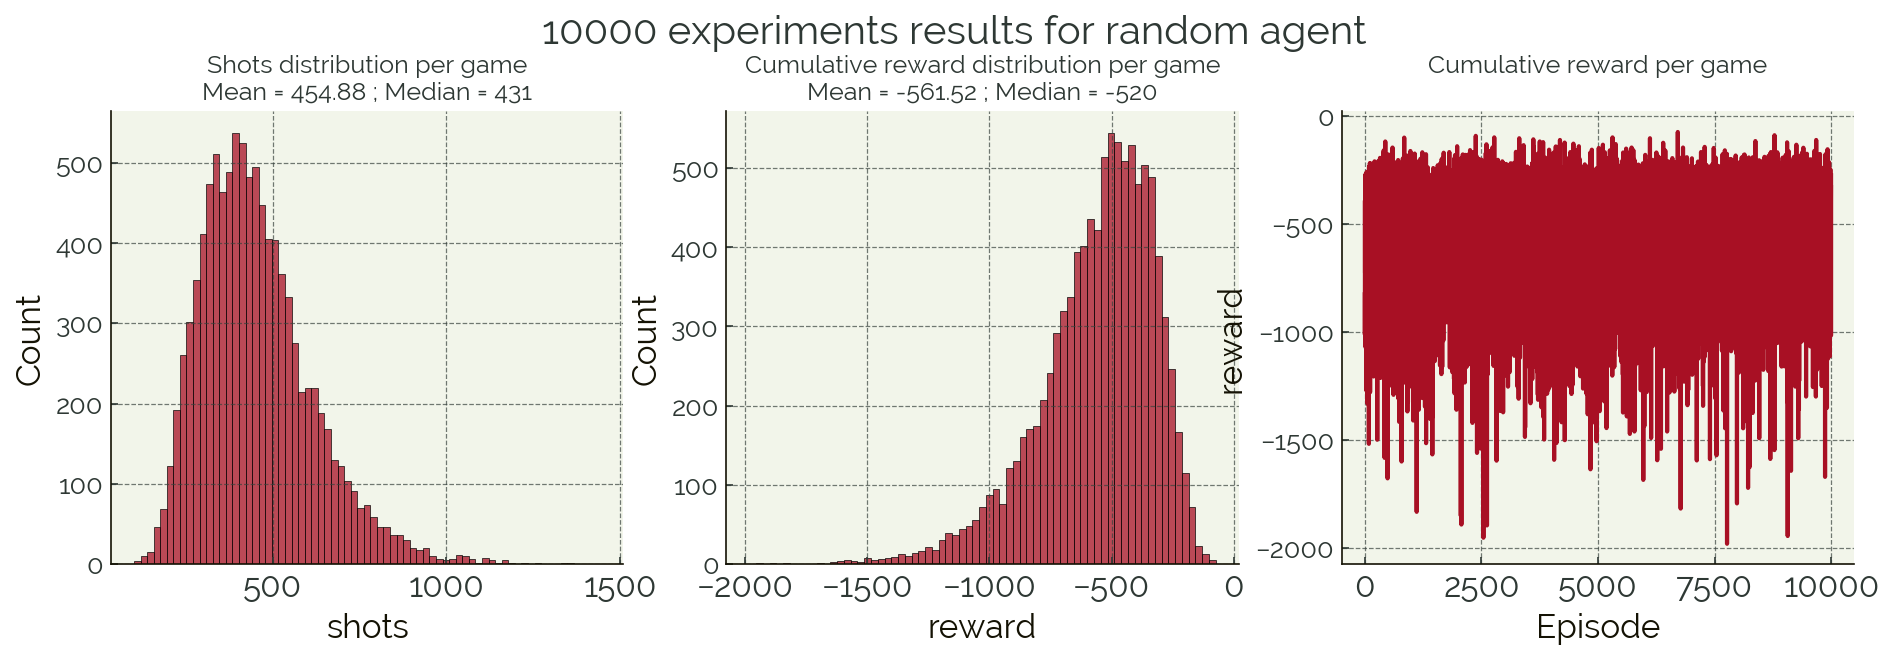

,reward,shots
count,10000.000000,10000.000000
mean,-561.517100,454.880100
std,239.310521,163.361038
min,-1982.000000,101.000000
25%,-688.000000,336.750000
50%,-520.000000,431.000000
75%,-389.000000,543.000000
max,-74.000000,1443.000000


In [17]:
process_results(randomResults, agent_type = 'random')

### Naive Q-learning Agent

The first naive agent I can think of follows a simple $\epsilon$-greedy policy with a simplified "game memory". 

For each step, the agent has a $\epsilon$ chance of chosing a completely random position to shoot at, to explore new possibilities. 

The other $1-\epsilon \ \%$ of the time, the action is chosen among already known situations. But with a $10\times10$ grid and 5 ships to place, the configuration possibilities are far too numerous to be efficiently remembered.

However, as the placement is random in each game, and the agent does not know when he hits a ship or not, its choices are actually fairly simple. The only determining action is to strike whether a 0 square, a -1 square, a -2 square or anyting else. 

Indeed, given that the agent has no idea where the ships are or if it already hit one, there is no difference between hitting a 0 square at the bottom right corner of the board or right at the middle (supposing that the distribution is uniform). There is a difference however between hitting a -1 square and a 0 square. For instance, if the 3 lives ships have already been sunk, there is no point at striking again a -2 square. So, the first idea I have is to reduce both the observation of the board and the striking possibilities to a few parameters, and then construct a Q-table for the agent to use. 


##### The observation

To identify a situation, the board game is reduced to 2 very simple parameters : 

 - The number of sunk ships (accessible through the *sunk_count* attribute of the environment).
 - The distribution of shots among squares.

The number of sunk ships is simply a list of length equal to the unique number of lives of the fleet. With the default fleet of $[1,2,2,2,3,3]$, we have $length=3$. Then, the integer at index 0 indicates the number of sunk ships of type 0, the integer at index 1 indicates the number of sunk ships of type 1...

In the first agent, only the number of sunk ships is taken into account for the decision. Methods to also consider the shot distribution will be discussed later. 

For now, only the type of squares bigger than -3 present are used. Meaning in a board with only 0 and -1 squares, the observation is represented as $(X,X,X,0,-1)$. But a board with 0, -1 and -5 squares will also be represented as $(X,X,X,0,-1)$.

##### The choice

Given a situation, as explained before, it is impossible to differentiate actions of bombing a 0-square at 2 different locations. 

What the agent must learn is to choose to bomb an unknown square, or a -1 square, a -2 square according to its observation. Once the "type" of square is chosen by the agent, the actual index targeted among corresponding squares is picked at random (supposing uniform distribution). 

##### The Q table

Given these assumptions, we can produce a very simple Q table for the agent to learn upon. 

The states are characterized by a list of 3 integers indicating the number of sunk ships of each type. For instance, the tuple $(1,2,1)$, if we started with the default fleet of $[1,2,2,2,3,3]$, means that two ships remain on the board : one ship with 2 lives and one ship with 3 lives (we don't know their current number of lives, only the number of lives they started with).

The action on the other hand are also reduced to very few possibilities : the agent picks a "type" of square and then shoots randomly one square of the corresponding square. 

Practically, the Q table is reprensented by a dictionary with 

 - The observation characterization $(X,X,X) + (types\ of\ squares\ present > -4)$ as key
 - Another dictionary where the key indicates the type of square (0 if the square hasn't been bombed, -1 if it has been bombed once...) and the value is the corresponding value for the Q function. 
 
### Flaws 

This approach has a lot of flaws, mainly that the observation is far too simplified for the agent to behave correctly. For instance, in a situation where a ship with 2 lives remain on the board, the agent cannot know if he should pick first the remaining -1 squares, or a 0 square. Knowing the shot distribution could help this decision. 

However, I expect this agent to works at least a little bit, mainly because of the fact that all ships take up 1 square and they are uniformly distributed. This means that there is no incentive for the agent to stay close to an already sunk ship to find others.


In [98]:
class Q_agent_V1 :
    
    def __init__(self,
                 fleet = [1,2,2,2,3,3], grid_size = 10, 
                 distribution = uniform(loc = -8, scale = 15)) :
        
        # Initates the game instance
        self.battleshipBoard = BattleshipEnv(fleet = fleet, grid_size = grid_size, 
                                        distribution = distribution)
        
        # A dictionary to store the Q table
        self.Q_table = {}
        
        # A dictionnary to store experiment results
        self.exp_results = {'reward' : [],
                            'shots' : []}
        
        self.errc = 0
        
    def play_episode (self, gameboard,
                      alpha = 0.5, gamma = 0.3,
                      epsilon = 0.3,
                      agent_seed = None, verbose = 0):
        """
        Parameters
        ----------
        epsilon : float
            A float between 0 and 1. Dictates the probability for the agent of taking a random choice instead of 
            refering to the Q table
            At each timestep, the agent has a epsilon probability of picking a random action. 
            
        alpha : float
            A float between 0 and 1 representing the learning rate in the update of the Q learning function
            
        gamma : float
            A float between 0 and 1 representing the importance of future rewards in the update of the Q learning function
        """
        
        agent_state = np.random.RandomState(seed = agent_seed)
        
        # Prints the starting state if required
        if verbose:
            print("Board initial state : ")
            print(gameboard.fleet_coords)
            gameboard.render_board()
            
        allSunk = False
        
        # while the game isn't solved
        while not(allSunk) :
            
            # Gets the current observation for the agent 
            squares_present = tuple(np.unique(gameboard.board_observation[gameboard.board_observation > -4]))
            current_obs = tuple(gameboard.sunk_count) + squares_present
            
            # If the random is under epsilon OR if the current observation is unseen before 
            # We take a random action
            if agent_state.random() < epsilon or not(self.Q_table.get(current_obs)):
                action = agent_state.randint(0,gameboard.grid_size**2)
                # Gets the square type matching the action
                square_type = gameboard.board_observation[action]
                    
            else :
                # First the type of square to shoot at is determined using the Q_table
                square_type = list(self.Q_table[current_obs].keys())[np.argmax(list(self.Q_table[current_obs].values()))]
                # Then, a random position matching this square type is picked
                action = agent_state.choice(np.where(gameboard.board_observation == square_type)[0])
               
            # We take the action and get the new obsevation
            _, gameboard.board_observation, reward = gameboard.take_step(action)
            gameboard.reward += reward
            # As explained, the observation is actually not the matrix board_observation 
            # but only the list of sunk ships
            squares_present = tuple(np.unique(gameboard.board_observation[gameboard.board_observation > -4]))
            new_obs = tuple(gameboard.sunk_count) + squares_present
            
            # If the square_type is more than -4, then the Q table is updated. Otherwise we don't care
            if square_type > -4 :
                # Gets the current value of the Q table for the this action and state
                # If it is the first time querying this observation, the value to all squares is defaulted to a -grid_size
                current_Qval = self.Q_table.setdefault(current_obs, {square : -gameboard.grid_size for square in current_obs[len(gameboard.sunk_count):]})[square_type]
                # Same thing for the maximum future reward
                future_Qval = np.max(list(self.Q_table.setdefault(new_obs, {square : -gameboard.grid_size for square in new_obs[len(gameboard.sunk_count):]})))

                # Compute the learning element of the updating algorithm           
                learning_term = reward + gamma * future_Qval - current_Qval

                # Updates the corresponding value in the Q_table
                self.Q_table[current_obs][square_type] += alpha * learning_term                  
        
            # Prints the intermediate state if specified
            if verbose > 1 :
                gameboard.render_board()
            
            # The game continues until all ships are sunk
            allSunk = (sum(gameboard.sunk_count) == len(gameboard.fleet))
            
            
        # Prints the last true state
        if verbose :
            print('Board final state')
            gameboard.render_board()
            
        return gameboard.shots_count, gameboard.reward
            
    def train_agent(self, n_exps = 10000,
                    alpha = 0.5, gamma = 0.3, 
                    epsilon_start = 0.7, epsilon_decay = 0.99, epsilon_floor = 0.2,
                    agent_seed = None, board_seed = None,
                    verbose = 0) :
        
        # Creates a list of seeds for both the agent behavior and the board initialization
        agent_seeds = np.random.RandomState(seed = agent_seed).randint(0, 2**30, n_exps)
        board_seeds = np.random.RandomState(seed = board_seed).randint(0, 2**30, n_exps)
        
        epsilon = epsilon_start
        
        for idx, (agent_seed, board_seed) in enumerate(zip(agent_seeds, board_seeds)):
            
            
            self.battleshipBoard.reset_board(board_seed)
            
            shots, reward = self.play_episode(self.battleshipBoard, 
                                              alpha = alpha, gamma = gamma,
                                              epsilon = epsilon,
                                              agent_seed = agent_seed, verbose = verbose)
            
            self.exp_results['reward'].append(reward)
            self.exp_results['shots'].append(shots)
            
            # Updates the epsilon value :
            if idx % 50 == 0:
                epsilon = max(epsilon*epsilon_decay, epsilon_floor)
            
        return pd.DataFrame(self.exp_results)

In [101]:
QAgent = Q_agent_V1()

QV1_results = QAgent.train_agent(agent_seed = 2, board_seed = 10, n_exps = 50000, verbose = 0)

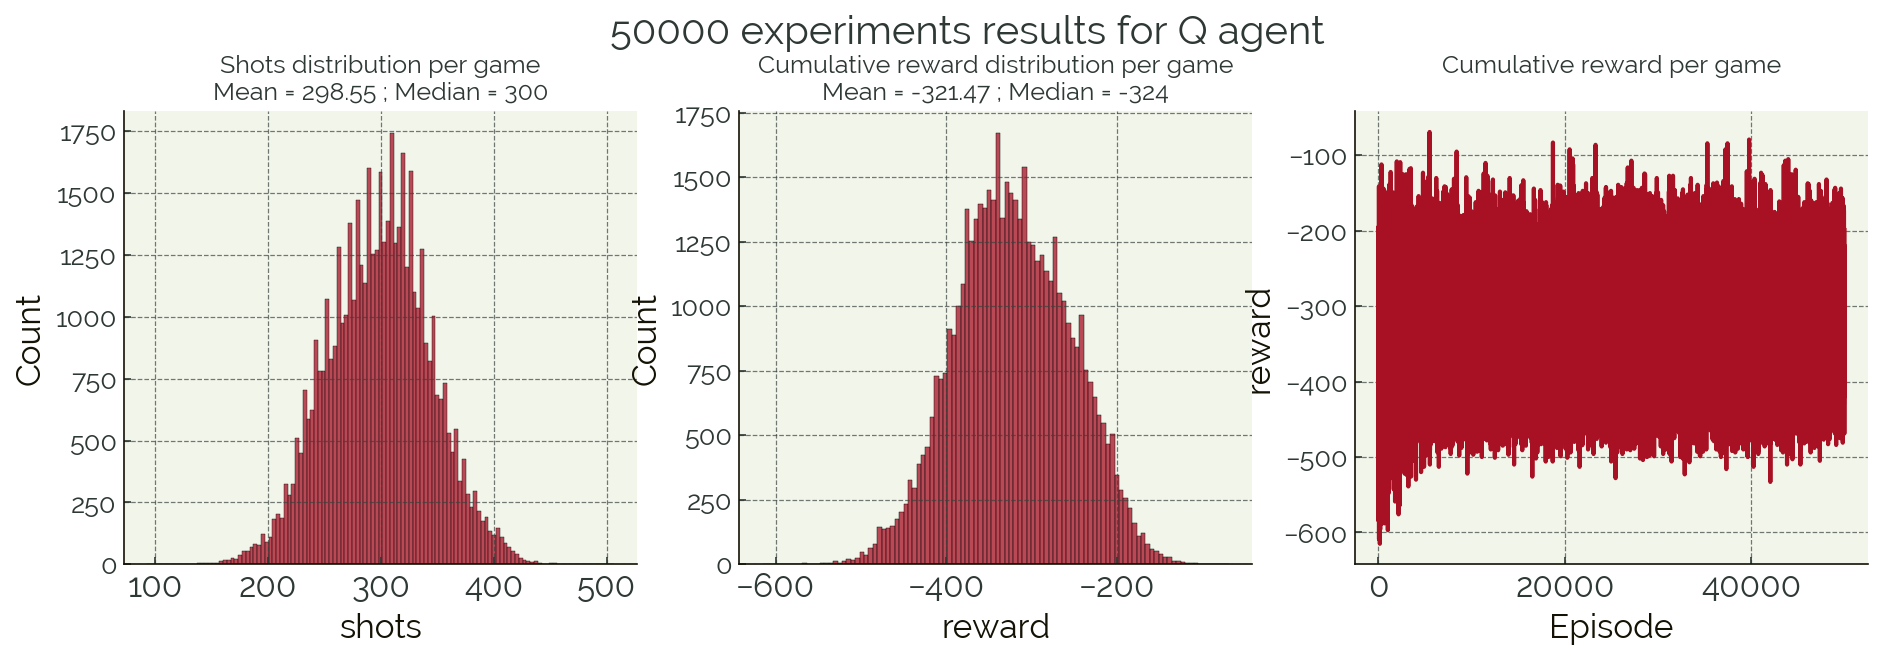

,reward,shots
count,50000.000000,50000.000000
mean,-321.469500,298.552100
std,67.416158,45.508537
min,-615.000000,93.000000
25%,-368.000000,267.000000
50%,-324.000000,300.000000
75%,-273.000000,329.000000
max,-69.000000,506.000000


In [103]:
process_results(QV1_results, agent_type = 'Q')

#### Characterizing the shot distribution

The distribution of shots among squares is represented by ordering the type of squares and building in an ordered list where the most frequent squares appears first, followed by the second most frequent type of square, etc...

For instance, at the beginning of the game, as no squares have been bombed, the distribution is uniquely represented by the vector $(0)$. 
After one shot on a random position, the distribution is represented by the vector $(0,-1)$ (as most squares are still 0, but 1 square is at -1). 

The following board (where shots are represented by an x) :

     x |   | xx
    -----------
       | x | 
    -----------
     x | x | x  
    
is represented by the following vector : $$(-1, 0, -2)$$

Because most squares are at -1, while one is at -2 and three still at 0. 

The parameters are then concatenated to form one complete list loosely characterizing the observation. 

For instance, if on the last grid, the ships where positioned as shown here : 

     2 |   | 2
    -----------
       |   | 1
    -----------
     3 |   |   
    
We can notice that only the ship with 2 lives on the top right corner has been sunk, and thus this complete observation is characterized by : 

$$(0,1,0,-1,0,-2)$$

### Deep Q model

https://towardsdatascience.com/deep-reinforcement-learning-with-python-part-2-creating-training-the-rl-agent-using-deep-q-d8216e59cf31

In [89]:
import torch.nn as nn
import torch.nn.functional as F

class QNet (nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 2, stride = 1)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 100)

    def forward(self, observation):
        output = F.relu(self.conv1(observation))
        output = self.fc1(output)
        output = self.fc2(output)

        return output

def DQN_agent(net, env, 
              verbose = 0, agent_seed = None, batch_size = 10):
    
    exp_memory = []
    
    